# Averaged Artifact Substraction with EEG Data
## First step prepare Jupyter Notebook

In [11]:
import os
import sys
import mne
from facet.facet import facet
from loguru import logger
from mne.annotations import Annotations
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("../../src")
from facet.Epilepsy.template_utils import annotate_spike, extract_template, find_spike_template, extract_median_spike, backproject_ic_to_sensor, plot_spike_template
from facet.Epilepsy.template_utils import detect_spike_matches, plot_match_with_template, basic_clean, compute_adaptive_threshold, scale_eeg_to, find_spike_matches_all_channels
import scipy.stats as st
from scipy.signal import find_peaks

os.getcwd()
os.chdir(os.path.dirname(os.path.abspath("__file__")))
logger.remove()
logger.add(sys.stderr, level="INFO")
logger.add("facet.log", level="DEBUG")

f = facet()

## Second Step import EEG Data and process

2025-06-11 23:34:09.844 | INFO     | facet.facet:import_eeg:33 - Importing EEG from ../datasets/chb01_03.edf


Unknown or mismatched units:  → uv. No scaling.
Adaptive reject threshold ≈ 1796.3 µV


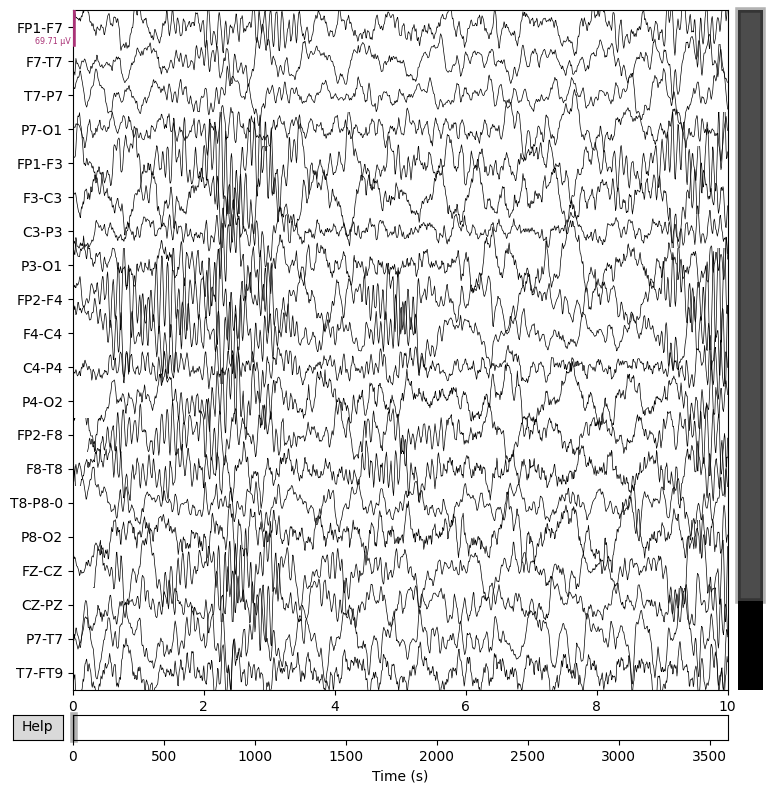

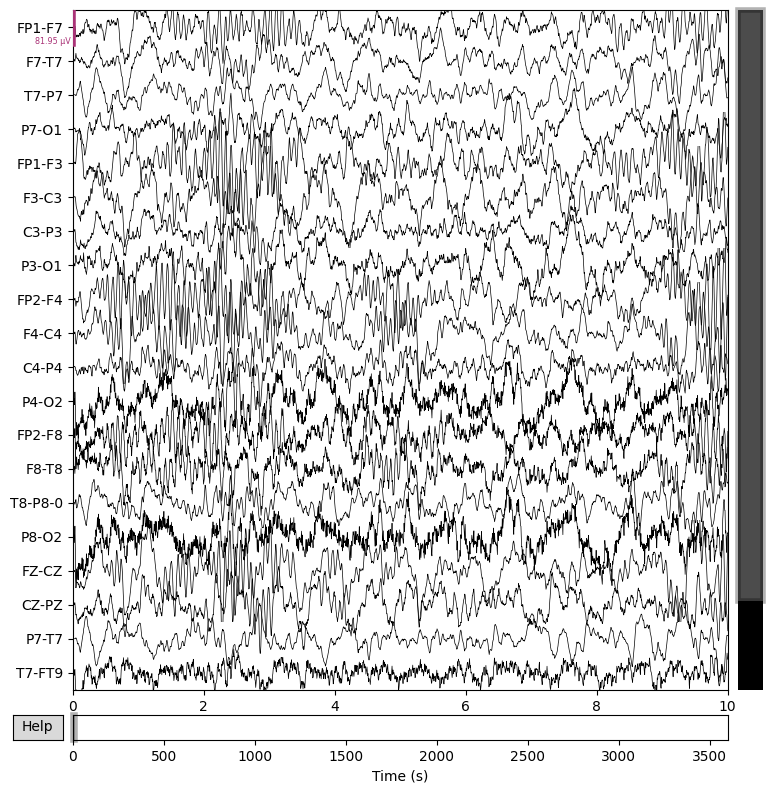

In [12]:
# Step 1 — Import EEG with FACET
eegDataSet = "../datasets/chb01_03.edf"
f.import_eeg(eegDataSet, artifact_to_trigger_offset=-0.005, bads=["EMG", "ECG"])
raw = f.get_eeg().mne_raw


raw = scale_eeg_to(raw, target="uV") #convert from volts (as often in CHB-MIT) to microvolts (µV)
raw.set_montage('standard_1020', on_missing='warn')
    

# quick robust estimate of channel peak-to-peak
thr = compute_adaptive_threshold(raw)
print(f"Adaptive reject threshold ≈ {thr:.1f} µV")


# band-pass, notch, crop and ICA – all in one helper
raw_clean, ica = basic_clean(
        raw,
        l_freq    = 1. ,
        h_freq    = 40.,
        notch     = 50 ,
        crop_tmin = 10,     # skip first 10 s
        crop_tmax = 180,    # analyse up to 180 s
        ica_var   = 0.99,
        reject_uV = thr
)


raw_clean.plot(start=0, duration=10, scalings='auto')

raw.plot(start=0, duration=10, scalings='auto')
plt.close("all")


### Perform ICA

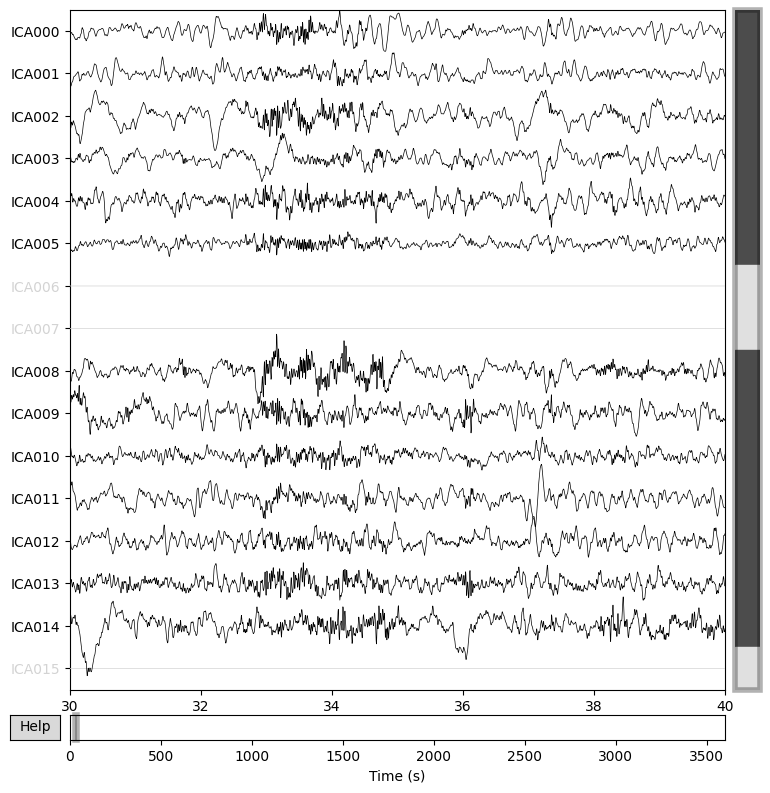

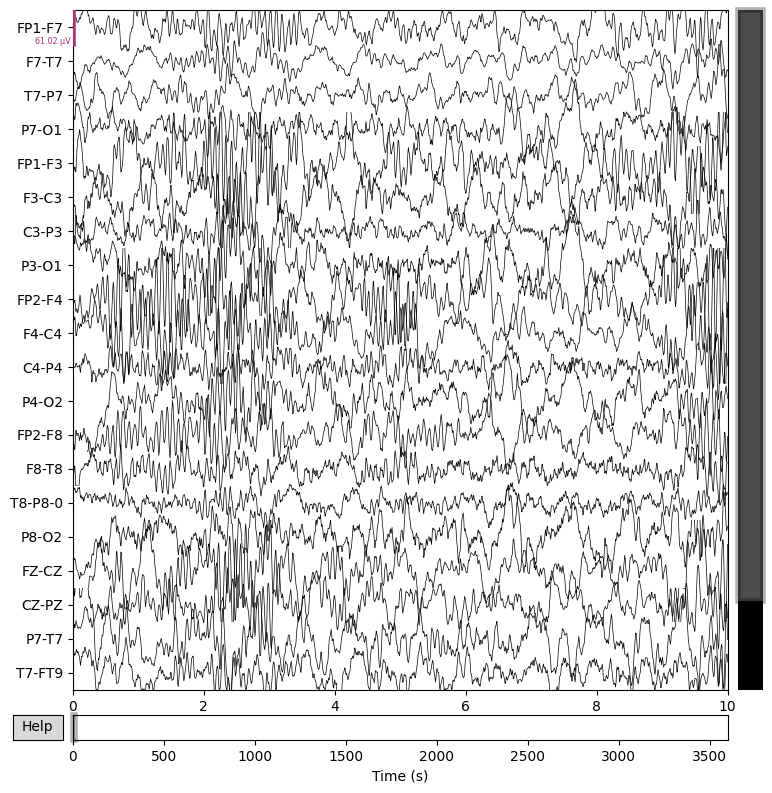

In [14]:

ica.plot_sources(raw_clean, start=30, stop=40)  # This is safe and works
# Manually exclude:
ica.exclude = [6, 7, 15]  # for example

ica.apply(raw_clean)

raw_clean.plot(start=0, duration=10, scalings='auto')
plt.close("all")

### Find most spiky IC

In [15]:
# 1) Rank ICs by kurtosis (spikes → high kurtosis)
import scipy.stats as st
ics = ica.get_sources(raw_clean).get_data()
kurt = [st.kurtosis(ics[i]) for i in range(ics.shape[0])]
best_ic = int(np.argmax(kurt))          # index of the spikiest component
print(f"Most-spiky IC ≈ ICA{best_ic:03d}  (kurtosis={kurt[best_ic]:.1f})")

Most-spiky IC ≈ ICA014  (kurtosis=6.9)


### Detect peaks in that IC and build a median template

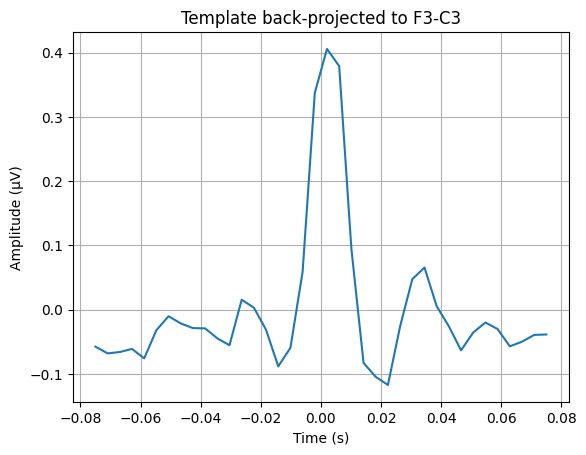

In [16]:
# Extract most spiky IC signal and build template
sig = ics[best_ic]
sfreq = raw_clean.info['sfreq']
template_ic = extract_median_spike(sig, sfreq)

# Back-project to EEG and plot one selected sensor
template = backproject_ic_to_sensor(template_ic, best_ic, raw_clean, ica, sensor="F3-C3")
plot_spike_template(template, title="Template back-projected to F3-C3")

## Cross correlation through all channels using the template

Unknown or mismatched units:  → uv. No scaling.
FP1-F7: 2 matches
T7-P7: 1 matches
FP2-F4: 1 matches
T8-P8-0: 1 matches
FZ-CZ: 1 matches
P7-T7: 1 matches
T8-P8-1: 1 matches
F7-T7: 0 matches
P7-O1: 0 matches
FP1-F3: 0 matches
F3-C3: 0 matches
C3-P3: 0 matches
P3-O1: 0 matches
F4-C4: 0 matches
C4-P4: 0 matches
P4-O2: 0 matches
FP2-F8: 0 matches
F8-T8: 0 matches
P8-O2: 0 matches
CZ-PZ: 0 matches
T7-FT9: 0 matches
FT9-FT10: 0 matches
FT10-T8: 0 matches

Best single match: T8-P8-0 at 2342.42s (score = 0.84)


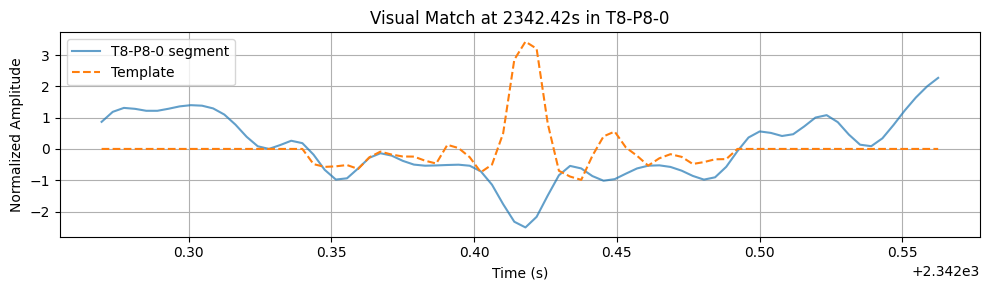

In [17]:
channel_scores = {}
top_score = -np.inf
top_channel = None
top_time = None
raw_for_templates = raw_clean
raw_for_templates = scale_eeg_to(raw_clean, target="uV")

channel_scores, top_channel, top_time, top_score = find_spike_matches_all_channels(
    raw_for_templates, template, threshold_ratio=0.8
)

# Print match summary
for ch, count in sorted(channel_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{ch}: {count} matches")

if top_time is not None:
    print(f"\nBest single match: {top_channel} at {top_time:.2f}s (score = {top_score:.2f})")
    plot_match_with_template(raw_for_templates, top_channel, [top_time], template, raw_clean.info['sfreq'])
else:
    print("\nNo spike match passed the threshold on any channel.")